In [132]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation
import matplotlib
import scipy.sparse as sps
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# matplotlib.rcParams['figure.figsize'] = [8, 7]
from IPython.display import clear_output

## Initializing the Mesh

In [133]:
domain_length = 1
meshsize = 200

dx = domain_length/meshsize*np.ones((meshsize))

x = np.ones((meshsize))
x[0] = dx[0]/2
for i in range(1,meshsize):
    x[i] = x[i-1] + dx[i-1]/2+dx[i]/2

## Entering phase diagram properties

In [134]:
c0 = 2.1

ceut = 4.2
calpha = 2.1

Tf = 1537
Teut = 1153

Tliq = (Teut-Tf)/ceut*c0 + Tf
Tsol = (Teut-Tf)/calpha*c0+Tf

kpar = calpha/ceut
T_init_cast = Tliq

c = c0*np.ones((meshsize))
cinit = c.copy()

def cl(T, Tf=Tf, ceut=ceut, Teut=Teut):
    return (T-Tf)*ceut/(Teut-Tf)

def TfromCl(cl, Tf=Tf, ceut=ceut, Teut=Teut):
    return cl/ceut*(Teut-Tf)+Tf


In [135]:
final_t = 2000

#Defining temperature as a function of time. Linear, no diffusion

def temp(time,Tsol=Tsol,Tliq=Tliq,tf=final_t):
    return Tliq + (Tsol-Tliq)*time/tf

def timeFromTemp(temp, Tsol=Tsol, Tliq=Tliq, tf=final_t):
    return (temp-Tliq)/(Tsol-Tliq)*tf

## Diffusion

In [136]:
def diffusion_step(dx,c,dt,D,b1,b2,theta=1):
    
    meshsize = len(dx)
    r = np.zeros(meshsize)

    r[0] , r[meshsize-1] = 1/b1,1/b2
    r[1:meshsize-1] = dx[1:meshsize-1]/(2*D)
    
    hcon = np.zeros(meshsize)
    hcap = np.zeros(meshsize)

    for i in range(1, meshsize):
        hcon[i] = 1/(r[i-1]+r[i])

    for i in range(1, meshsize-1):
        hcap[i] = dx[i]/dt

    Att= calcAtt(hcon,hcap,theta=theta)
    At= calcAt(hcon,hcap,theta=theta)

    return np.linalg.inv(Att)@At@c

def calcAtt(hcon, hcap,theta):
    size = len(hcap)
    Att = np.zeros((size, size))
    for i in range(0, size):
        # Left boundary condition constant concentration
        if i == 0:
            Att[i][i] = 1
            continue
        # Right boundary condition constant concentration
        if i == size-1:
            Att[i][i] = 1
            continue
        Att[i][i-1] = -theta*hcon[i]
        Att[i][i] = hcap[i] + theta*hcon[i] + hcon[i+1]*theta
        Att[i][i+1] = -theta*hcon[i+1]
    return Att
    
def calcAt(hcon, hcap,theta):
    size = len(hcap)
    At = np.zeros((size, size))
    for i in range(0, size):
        #Left boundary condition
        if i == 0:
            At[i][i] = 1
            continue
        #Right boundary condition
        if i == size-1:
            At[i][i] = 1
            continue
        At[i][i-1] = (1-theta)*hcon[i]
        At[i][i] = hcap[i]-(1-theta)*hcon[i]-(1-theta)*hcon[i+1]
        At[i][i+1] = (1-theta)*hcon[i+1]
    return At

In [137]:
def simulateScheilTimestep(dx, c, steps,Dsol,Dliq,fs_final=1, tf=final_t, k=kpar):
    
    length = np.sum(dx)
    meshsize = len(dx)
    c0 = np.average(c)
    c_initial = c.copy()
    t = 0

    #Concentrations inside stepped nodes

    profiles = []

    #Total mass
    total_mass = length*c0

    for inter in tqdm(range(0,round(fs_final*meshsize))):
        
        concentrations = c[inter]*np.ones((steps))
        
        # Iterating over nodes
        for step in range(steps):

            T_old = temp(t)
            
            solid_dx = np.concatenate(([dx[0]], dx[0:inter], [dx[inter]]))
            liq_dx = np.concatenate(([dx[inter]], dx[inter+1:], [dx[-1]]))

            #### Analytical method
            #Find dt
            fs = (inter + step/steps)/meshsize
            dfs = 1/(steps*meshsize)

            cl_old = cl(T_old)
            cl_new = cl_old+ dfs/(1-fs)*cl_old*(1-k)
            # cl_new = cl_old+ dfs/(1+(k-1)*fs)*cl_old*(1-k)
            T = TfromCl(cl_new)

            dt = timeFromTemp(T)-t
            t= t+dt
            
            ## Updating the values using new interface

            # Diffusion in solid and liquid
            solid_c = np.concatenate(([c[0]], c[0:inter], [k*cl(T)]))
            liq_c = np.concatenate(([cl(T)], c[inter+1:], [c[-1]]))
            
            sol_flux = 0

            new_c = np.zeros((meshsize))
            new_concentrations = np.zeros((steps))

            #Scheil model
            new_solid = solid_c[1:-1]
            
            new_c[0:inter] = new_solid[0:inter]
            new_concentrations[:step] = concentrations[:step]
            new_concentrations[step] = k*cl(T)
            new_concentrations[step+1:] = cl(T)
            new_c[inter] = np.average(new_concentrations)

            #Solve liquid flux using sol_flux
            interface_flux = dx[inter]*(new_c[inter]-c[inter])
            liq_flux = -(interface_flux+sol_flux)
            beta_liq = 1/((cl(T)-c[inter+1])/liq_flux-dx[inter+1]/(2*Dliq))

            new_liquid = diffusion_step(liq_dx, liq_c, dt, Dliq, beta_liq, 1E-24)[1:-1]

            new_c[inter+1:] = new_liquid[:]
            
            c=new_c.copy()
            concentrations = new_concentrations.copy()
            
            mass_change = (np.sum(dx*c) -np.sum(dx*c_initial))

            profiles_dx = np.concatenate((solid_dx[1:-1],liq_dx[1:-1]))
            profiles_x = np.ones((len(profiles_dx)))
            profiles_x[0] = profiles_dx[0]/2
            for i in range(1,len(profiles_dx)):
                profiles_x[i] = profiles_x[i-1] + profiles_dx[i-1]/2+profiles_dx[i]/2
                
            profiles_c = np.concatenate((new_solid,new_liquid))
            
            profiles.append(((profiles_x.copy(),profiles_c.copy()), inter+step/steps,mass_change,t,concentrations.copy()))
        
    return profiles


In [138]:
def simulateLeverTimestep(dx, c, steps,fs_final=1, tf=final_t, k=kpar):
    
    length = np.sum(dx)
    meshsize = len(dx)
    c0 = np.average(c)
    c_initial = c.copy()
    t = 0
    #Interface node
    inter = 0
    # Step inside interface node
    step = 0
    #Concentrations inside stepped nodes

    profiles = [(c.copy(), 0,0,t)]

    # #Total mass
    # total_mass = length*c0

    # #Guess initial dt
    # dt = 0.3

    for inter in tqdm(range(0,round(fs_final*meshsize))):
        
        concentrations = c[inter]*np.ones((steps))

        # #Finding out the solid part
        # isSolid = np.zeros((len(x)))
        # isLiquid = np.zeros((len(x)))
        # isSolid[0:inter] = dx[0:inter]
        # isLiquid[inter+1:] = dx[inter+1:]
        
        # Iterating over nodes
        for step in range(0,steps):

            T_old = temp(t)

            # change = 1

            # while abs(change)>1E-5:
                
            #     T = temp(t+dt)

            #     # Mass Change
            #     solid_change = np.sum(np.dot(isSolid, c)) - np.sum(np.dot(isSolid, c))
            #     liquid_change = np.sum(np.dot(isLiquid, cl(T))) - np.sum(np.dot(isLiquid, c))
                
            #     # Interface mass change
            #     el_len = dx[inter]/steps
            #     inter_change = el_len*(k*cl(T) - cl(T_old)) + el_len*(steps-(step+1))*(cl(T)-cl(T_old))
                
            #     #Remaining mass
            #     change = inter_change+solid_change+liquid_change
                
            #     dt = dt*(1-change/total_mass/10)

            #Find dt
            fs = (inter + step/steps)/meshsize
            dfs = 1/(steps*meshsize)

            cl_old = cl(T_old)
            cl_new = cl_old+ dfs/(1+(k-1)*fs)*cl_old*(1-k)
            T = TfromCl(cl_new)

            t = timeFromTemp(T)
            
            ## Updating the values using new interface

            # Diffusion in solid and liquid
            # Interface
            concentrations[:step+1] = k*cl(T)
            concentrations[step+1:] = cl(T)
            # Solid diffusion
            c[:inter] = k*cl(T)
            # Liquid Diffusion
            c[inter+1:] = cl(T)

            c[inter] = np.average(concentrations)
            mass_change = (np.sum(dx*c) -np.sum(dx*c_initial))

            profiles.append((c.copy(), inter,mass_change,t))
        
        
    return profiles

In [139]:
steps = 15
Dsol = 1E-4
Dliq = 1E5
Simulation_result = simulateScheilTimestep(dx.copy(),c.copy(),steps,Dsol,Dliq,fs_final=0.8)

100%|██████████| 160/160 [00:14<00:00, 10.69it/s]


In [140]:
profiles = [Simulation_result[i][0] for i in range(len(Simulation_result))]
interface = [Simulation_result[i][1] for i in range(len(Simulation_result))]
mass_change = [Simulation_result[i][2] for i in range(len(Simulation_result))]
time = [Simulation_result[i][3] for i in range(len(Simulation_result))]
concentrations = [Simulation_result[i][4]for i in range(len(Simulation_result))]
dt = [time[i+1]-time[i] for i in range(len(time)-1)]

print(len(profiles))

2400


Tf = 2469.9019349511887 s


Text(0.5, 1.0, 'Time')

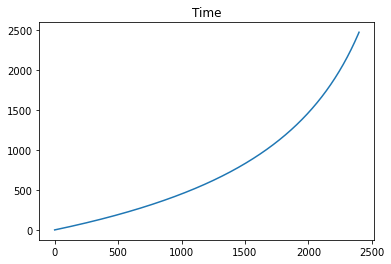

In [141]:
print("Tf = "+str(time[-1])+" s")
plt.plot(time)
plt.title('Time')

0.33350005557271817


Text(0.5, 1.0, 'dt')

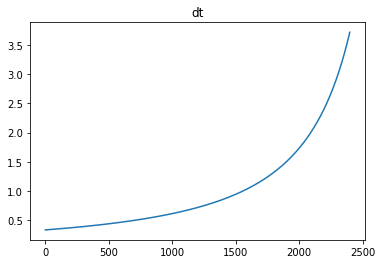

In [142]:
print(dt[0])
plt.plot(dt)
plt.title('dt')

In [143]:
fs = 1
index_f = int(fs*len(profiles))
# index = 12
@interact(index=(0,index_f-1))
def plot(index):
    plt.clf()
    plt.plot(profiles[index][0],profiles[index][1])
    plt.title('profile')
    
    # plt.ylim(1,np.max(profiles[-1][1]))
    plt.show()

interactive(children=(IntSlider(value=1199, description='index', max=2399), Output()), _dom_classes=('widget-i…

Text(0.5, 1.0, 'dm vs t')

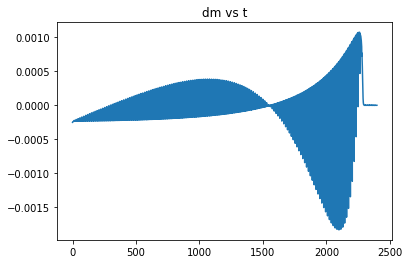

In [149]:
dm = [mass_change[i+1]-mass_change[i] for i in range(len(mass_change)-1)]
plt.plot(dm[:])
plt.title('dm vs t')

-0.0007188599284981834


Text(0.5, 1.0, 'Mass Change vs time')

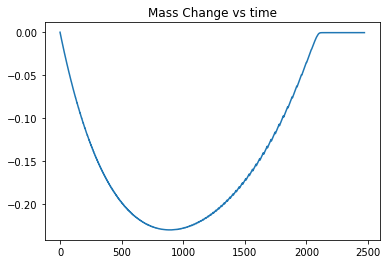

In [145]:
plt.plot(time,mass_change)
print(mass_change[-1])
plt.title('Mass Change vs time')

Text(0.5, 1.0, 'Interface movement')

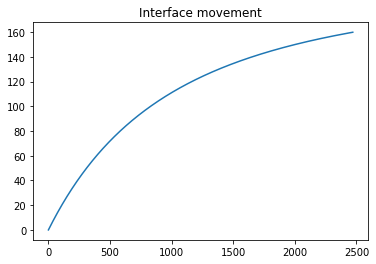

In [146]:
plt.plot(time,interface)
plt.title('Interface movement')